In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst."
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic."
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives."
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\n Role: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliation."
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking question


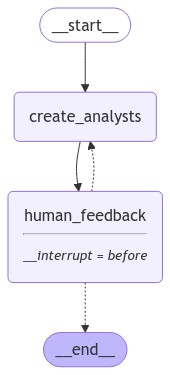

In [8]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                 human_analyst_feedback=human_analyst_feedback,
                                                 max_analysts=max_analysts 
                                                )
    
    # Generate question
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)] + 
        [HumanMessage(content="Generate the set of analysts.")]
        )

    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))



In [9]:
# Input
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how such frameworks can enhance operational efficiency and drive innovation within organizations.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: Data Security Solutions
Role: Data Security Analyst
Description: Mr. Smith is concerned with the security implications of adopting new frameworks. His focus is on ensuring that LangGraph can be integrated without compromising data integrity and security.
--------------------------------------------------
Name: Dr. Sarah Lee
Affiliation: AI Ethics Consortium
Role: Ethical AI Advocate
Description: Dr. Lee examines the ethical considerations of implementing AI frameworks like LangGraph. She is dedicated to ensuring that the adoption of such technologies aligns with ethical standards

In [12]:
# Examine the state
state = graph.get_state(thread)
print(state)
print(state.next)

StateSnapshot(values={'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3, 'analysts': [Analyst(affiliation='Tech Innovators Inc.', name='Dr. Emily Carter', role='Technology Adoption Specialist', description='Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how such frameworks can enhance operational efficiency and drive innovation within organizations.'), Analyst(affiliation='Data Security Solutions', name='Mr. John Smith', role='Data Security Analyst', description='Mr. Smith is concerned with the security implications of adopting new frameworks. His focus is on ensuring that LangGraph can be integrated without compromising data integrity and security.'), Analyst(affiliation='AI Ethics Consortium', name='Dr. Sarah Lee', role='Ethical AI Advocate', description='Dr. Lee examines the ethical considerations of implementing AI frameworks like LangGraph. She is dedicated to ensuring

In [14]:
# Update the state with human feedback. This is the human_feedback 'node'
value = graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")
print(value)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efea141-e6f7-6994-8003-679b644276e2'}}


In [15]:
# Continue the graph execution from the human_feedback
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 







Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how such frameworks can enhance operational efficiency and drive innovation within organizations.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: Data Security Solutions
Role: Data Security Analyst
Description: Mr. Smith is concerned with the security implications of adopting new frameworks. His focus is on ensuring that LangGraph can be integrated without compromising data integrity and security.
--------------------------------------------------
Name: Dr. Sarah Lee
Affiliation: AI Ethics Consortium
Role: Ethical AI Advocate
Description: Dr. Lee examines the ethical considerations of implementing AI frameworks like LangGraph. She is dedicated to ensuring that the adoption of such technologies aligns with ethical standards

In [16]:
# If we are satisfied, then we simply do not supply feeback and let 
# the graph execution progress to the END node
further_feedback = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efea14a-f7bd-6ddc-8005-f3a939c00ea2'}}

In [17]:
for event in graph.stream(None, thread, stream_mode="values"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
topic


In [20]:
final_state = graph.get_state(thread)
print(final_state)
analysts = final_state.values.get('analysts')
print(analysts)

StateSnapshot(values={'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3, 'analysts': [Analyst(affiliation='Tech Startup', name='Alex Johnson', role='Entrepreneur', description='Alex is a co-founder of a tech startup that focuses on developing innovative AI solutions. He is interested in how adopting LangGraph can streamline development processes, reduce costs, and enhance product scalability. His primary concern is ensuring that the framework can integrate seamlessly with existing systems and support rapid iteration.'), Analyst(affiliation='Academic Institution', name='Dr. Emily Chen', role='Researcher', description='Dr. Chen is a leading researcher in AI frameworks and their applications. Her focus is on the theoretical benefits of LangGraph, such as its ability to improve computational efficiency and facilitate complex problem-solving. She is motivated by the potential for LangGraph to advance academic research and contribute to the broader AI com

In [21]:

for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alex Johnson
Affiliation: Tech Startup
Role: Entrepreneur
Description: Alex is a co-founder of a tech startup that focuses on developing innovative AI solutions. He is interested in how adopting LangGraph can streamline development processes, reduce costs, and enhance product scalability. His primary concern is ensuring that the framework can integrate seamlessly with existing systems and support rapid iteration.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: Academic Institution
Role: Researcher
Description: Dr. Chen is a leading researcher in AI frameworks and their applications. Her focus is on the theoretical benefits of LangGraph, such as its ability to improve computational efficiency and facilitate complex problem-solving. She is motivated by the potential for LangGraph to advance academic research and contribute to the broader AI community.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Large Te